In [33]:
%matplotlib inline
import numpy as np
import os
import pickle 
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt

In [7]:
# Expected shape is 1175 Trials x 13 channels x 15000 samples (@ 5000Hz) - value is potential
raw_source_dir = "median_labelled/"

files = ['x', 'y_median_per_recording'] # Also consider y.pickle (unlabeled)
file_data = []
for i, fn in enumerate(files):
    with open(os.path.join(raw_source_dir, '{}.pickle'.format(fn)), 'rb') as f:
        file_data.append(np.array(pickle.load(f)))
        
x = file_data[0]
y = file_data[1]

(1453,)
[0.00086892 0.00038629 0.000167   ... 0.02218963 0.01592537 0.01004619]
[1 0 0 ... 1 1 0]


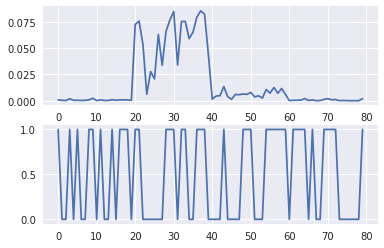

In [103]:
with open(os.path.join(raw_source_dir, 'y.pickle'), 'rb') as f:
    y_norm = np.array(pickle.load(f))
print(y_norm.shape)
print(y_norm)
fig, ax = plt.subplots(2,1)
plt.figure(figsize=(30,10))
ax[0].plot(y_norm[:80])
ax[1].plot(y[:80])
print(y)

In [8]:
seed = 1
np.random.seed(seed)

In [9]:
# Referencing http://forrestbao.blogspot.com/2009/10/eeg-signal-processing-in-python-and.html
# And https://www.ritchievink.com/blog/2017/04/23/understanding-the-fourier-transform-by-example/

# Sliding window spectrogram

def create_spectrogram(eeg_signal, save=False, save_name='x_fft.pickle', fs=5000.0, window_length=2500, step_size=50, banded_freq=40):
    # Shape trials x channels x samples

    # Create windows
    sample_length = eeg_signal.shape[-1]
    
    # Hyperparams
    # fs: sampling frequency
    # window_length : snippet to take fft over. resolution = fs/window_length
    # step_size: how fast to roll the window
    # banded_freq: how many steps of the frequency output to take - freq range [0, resolution * banded_freq]
    
    roll_cap = (sample_length - window_length)//step_size + 1 # Number of windows
    roll_ctr = 0
    # return trial x channel x windows x freq band
    fft_over_time = np.zeros((eeg_signal.shape[0], eeg_signal.shape[1], roll_cap, banded_freq))

    # Could consider vectorizing...
    while roll_ctr < roll_cap:
        window_sample = eeg_signal[...,roll_ctr * step_size: roll_ctr * step_size + window_length]
        fft_over_time[..., roll_ctr,:] = np.abs(np.fft.rfft(window_sample)[...,:banded_freq]) / window_length # fft over whole time frame
        roll_ctr += 1
    if save:
        with open(save_name, "wb") as pf:
            pickle.dump(fft_over_time, pf)
        print("Done pickling {}".format(save_name))
    return fft_over_time
    

In [11]:
def create_angles_spec(eeg_signal, save=False, save_name='x_angles.pickle', fs=5000.0, window_length=2500, step_size=50, banded_freq=40):
    # Create windows
    sample_length = eeg_signal.shape[-1]
    
    # Hyperparams
    # fs: sampling frequency
    # window_length : snippet to take fft over. resolution = fs/window_lenth
    # step_size: how fast to roll the window
    # banded_freq: how many steps of the frequency output to take - freq range [0, resolution * banded_freq]
    
    roll_cap = (sample_length - window_length)//step_size + 1 # Number of windows
    roll_ctr = 0

    fft_over_time = np.zeros((eeg_signal.shape[0], eeg_signal.shape[1], roll_cap, banded_freq))
    # Masking threshold for noise
    signal_thresh = .1
    while roll_ctr < roll_cap:
        window_sample = eeg_signal[...,roll_ctr * step_size: roll_ctr * step_size + window_length]
        fft = np.fft.rfft(window_sample)[...,:banded_freq] # use as mask
        fft_over_time[..., roll_ctr,:] = np.where(np.abs(fft)/window_length > signal_thresh, np.angle(fft), 0)
        roll_ctr += 1
    if save:
        with open(save_name, "wb") as pf:
            pickle.dump(fft_over_time, pf)
        print("Done pickling {}".format(save_name))
    return fft_over_time
    

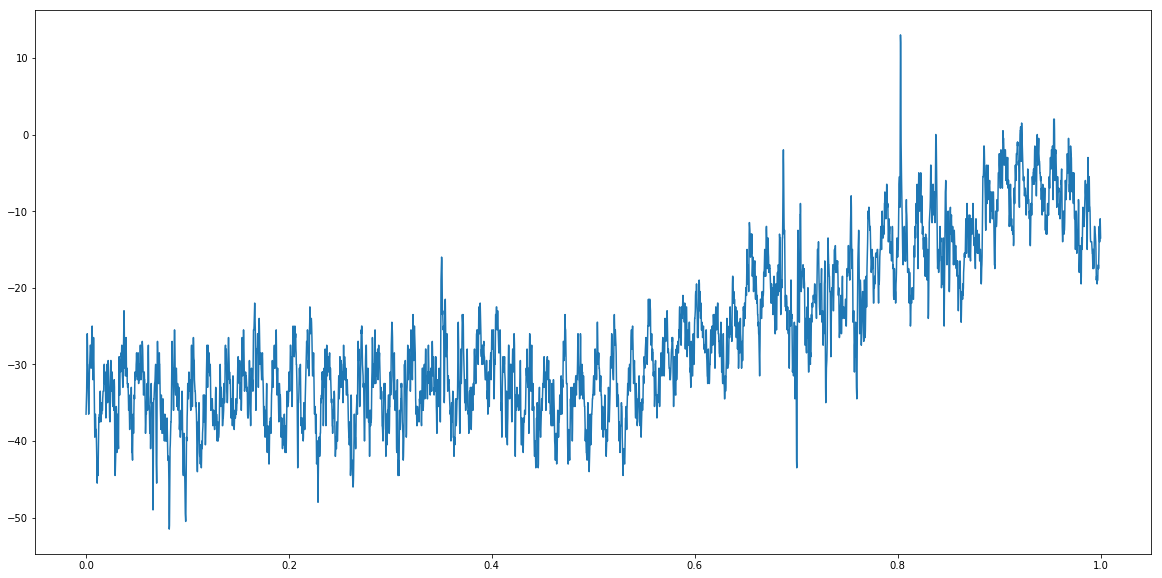

In [12]:
t = np.linspace(0, 1, x[0,0].shape[0]) # length
plt.figure(figsize=(20,10))
plt.plot(t, x[0,0])

In [13]:
win_length = 4000
resolution = 5000/win_length
x_fft_all = create_spectrogram(x, 'x_fft.pickle', window_length=win_length, banded_freq=25)

Done pickling x_fft.pickle


(1452, 13, 21, 25)


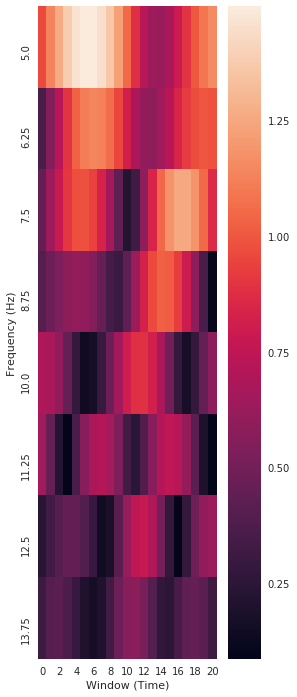

In [14]:
# Drop the first bin to account for DC offset
print(x_fft_all.shape)
# Find the channels with way too much power: > 3
freq_crop = x_fft_all[:,:3,:,4:12]
spectro = freq_crop[0,0].T

sns.set(rc={'figure.figsize':(4,12)})
ax = sns.heatmap(spectro, yticklabels=(np.arange(spectro.shape[0]) + 4)*resolution)
ax.set(ylabel='Frequency (Hz)', xlabel='Window (Time)')
plt.show()

In [16]:
angle_fft_all = create_angles_spec(x, window_length=4000, banded_freq=20) # resolution: 1.25

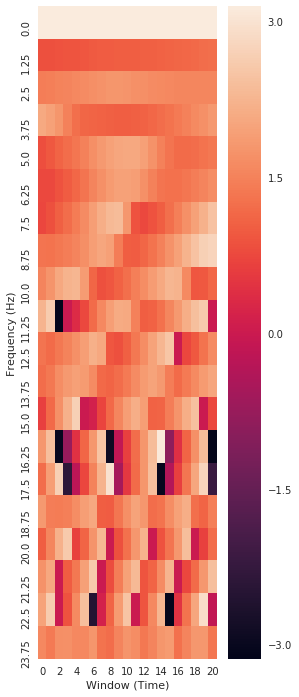

In [17]:
resolution=1.25
angle_spectro = angle_fft_all[0,0].T
ax = sns.heatmap(angle_spectro, yticklabels=np.arange(angle_spectro.shape[0])*resolution)
ax.set(ylabel='Frequency (Hz)', xlabel='Window (Time)')
plt.show()

In [96]:
print(angle_fft_all.shape)
# Take 3 channels
angle_flattened = angle_fft_all[:,:3,-4:,].reshape((angle_fft_all.shape[0], -1))
print(angle_flattened.shape)
a_x_tr, a_x_te, a_y_tr, a_y_te = train_test_split(angle_flattened, y_norm[:-1], test_size=.2, random_state=seed)

(1452, 13, 21, 20)
(1452, 240)


In [63]:
print(freq_crop.shape)
power_flattened = freq_crop[:,:,-2:].reshape((freq_crop.shape[0], -1)) # flatten channels, frequencies, and windows
print(power_flattened.shape)
x_tr, x_te, y_tr, y_te = train_test_split(power_flattened, y[:-1], test_size=.2, random_state=seed)
print(x_tr.shape)
print(y_tr.shape)

(1452, 3, 21, 8)
(1452, 48)
(1161, 48)
(1161,)


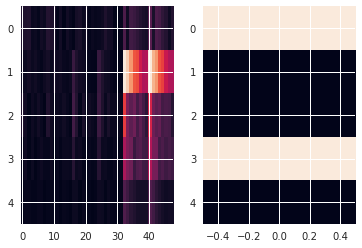

In [66]:
plt.subplot(121)
plt.imshow(power_flattened[:5], aspect='auto')
plt.subplot(122)
plt.imshow(np.array([y[:5]]).transpose(), aspect='auto')


In [56]:
from sklearn.neural_network import MLPClassifier 
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

clf = MLPClassifier(hidden_layer_sizes=(80,20), random_state=seed)
print(np.unique(y_tr,return_counts=True))
# clf = RandomForestClassifier()
clf.fit(x_tr, y_tr)

(array([0, 1]), array([578, 583]))


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(80, 20), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [98]:
from keras.models import Sequential
from keras.layers import Dense
angle_model = Sequential()
angle_model.add(Dense(50, input_dim=angle_flattened.shape[-1], activation='relu'))
angle_model.add(Dense(20, activation='relu'))
angle_model.add(Dense(1, activation='linear'))
# angle_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
angle_model.compile(loss='mse', optimizer='adam')
angle_model.fit(a_x_tr, a_y_tr, epochs=10, batch_size=8)

Epoch 1/10
1161/1161 [==============================] - 1s 661us/step - loss: 1.6485
Epoch 2/10
1161/1161 [==============================] - 0s 163us/step - loss: 0.1923
Epoch 3/10
1161/1161 [==============================] - 0s 154us/step - loss: 0.0836
Epoch 4/10
1161/1161 [==============================] - 0s 157us/step - loss: 0.0422
Epoch 5/10
1161/1161 [==============================] - 0s 159us/step - loss: 0.0248
Epoch 6/10
1161/1161 [==============================] - 0s 142us/step - loss: 0.0156
Epoch 7/10
1161/1161 [==============================] - 0s 155us/step - loss: 0.0105
Epoch 8/10
1161/1161 [==============================] - 0s 163us/step - loss: 0.0068
Epoch 9/10
1161/1161 [==============================] - 0s 211us/step - loss: 0.0049
Epoch 10/10
1161/1161 [==============================] - 0s 264us/step - loss: 0.0036


In [64]:
model = Sequential()
model.add(Dense(12, input_dim=power_flattened.shape[-1], activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x_tr, y_tr, epochs=50, batch_size=16)

Epoch 1/50
1161/1161 [==============================] - 0s 362us/step - loss: 0.8048 - acc: 0.5159
Epoch 2/50
1161/1161 [==============================] - 0s 71us/step - loss: 0.7737 - acc: 0.5022
Epoch 3/50
1161/1161 [==============================] - 0s 72us/step - loss: 0.7178 - acc: 0.5194
Epoch 4/50
1161/1161 [==============================] - 0s 71us/step - loss: 0.7529 - acc: 0.5142
Epoch 5/50
1161/1161 [==============================] - 0s 76us/step - loss: 0.7174 - acc: 0.5280
Epoch 6/50
1161/1161 [==============================] - 0s 73us/step - loss: 0.7311 - acc: 0.5237
Epoch 7/50
1161/1161 [==============================] - 0s 78us/step - loss: 0.7244 - acc: 0.5392
Epoch 8/50
1161/1161 [==============================] - 0s 79us/step - loss: 0.7218 - acc: 0.5340
Epoch 9/50
1161/1161 [==============================] - 0s 74us/step - loss: 0.7623 - acc: 0.5082
Epoch 10/50
1161/1161 [==============================] - 0s 79us/step - loss: 0.7256 - acc: 0.5202
Epoch 11/50
1161/1

In [84]:
a_y_pred_tr = angle_model.predict_classes(a_x_tr)
a_y_pred_te = angle_model.predict_classes(a_x_te)
print("Train:", accuracy_score(a_y_tr, a_y_pred_tr))
print("Test:", accuracy_score(a_y_te, a_y_pred_te))

Train: 0.9991386735572783
Test: 0.47079037800687284


In [65]:
y_pred_tr = model.predict_classes(x_tr)
print(y_pred_tr.shape)
y_pred_te = model.predict_classes(x_te)
print("Train:", accuracy_score(y_tr, y_pred_tr))
print("Test:", accuracy_score(y_te, y_pred_te))

(1161, 1)
Train: 0.5478036175710594
Test: 0.46735395189003437


In [49]:
predict = clf.predict(x_te)
u, counts = np.unique(y, return_counts=True)
print(counts)
print(predict[:100])
print(accuracy_score(predict, y_te))

[731 722]
[0 1 1 1 1 0 1 0 0 1 0 1 1 0 0 0 1 1 0 1 0 1 1 0 1 1 1 0 1 1 0 0 1 1 1 1 0
 0 0 0 1 1 0 1 1 0 0 1 1 1 0 0 1 0 1 0 1 1 0 1 0 1 1 1 0 1 1 0 0 0 0 1 1 0
 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 1 0 1 0 1 1 0 1 1 1]
0.46048109965635736


In [28]:

scores = cross_val_score(clf, power_flattened, y[:-1], cv=5)
print(scores)


[0.46391753 0.49140893 0.50344828 0.52413793 0.49310345]
